# CSCI 4050U Final Project - Predicting and Aiding Mental Well-Being from Social Media Usage

**Dataset:** *Students Social Media Addiction*
https://www.kaggle.com/datasets/adilshamim8/social-media-addiction-vs-relationships

**Note on different dataset**: After the project proposal was submitted, the original dataset proposed was removed and I was not able to recover a copy. I have found a replacement dataset that I have used to satisfy the original proposal requirements. 

### Project Goals
The first of the two main goals of my project are to use the Students' Social Media Addiction dataset to train a predictive model that estimates a user’s mental well-being score, or risk of poor mental health (**Mental_Health_Score**) based on features in the dataset such as screen time, number of platforms used, sleep quality, and self-evaluated mental well-being levels.

The second goal is to apply the trained model in a novel way by building a **personalized recommendation system** that suggests personalized lifestyle adjustments to help improve predicted mental health outcomes.

**Disclaimer:** This project is for educational purposes only and does not provide medical advice.

---
### Dataset Preview
This dataset contains survey-style data about students and their social media habits.  
For the purpose of this project, the data is broken down into the following key columns:

- `Avg_Daily_Usage_Hours`
- `Most_Used_Platform`
- `Sleep_Hours_Per_Night`
- `Affects_Academic_Performance`
- `Conflicts_Over_Social_Media`
- `Addicted_Score`
- `Mental_Health_Score`

---

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Dataset


In [2]:
df = pd.read_csv("Students Social Media Addiction.csv")
df.head()

,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [3]:
df.shape, df.columns.tolist()

((705, 13),
 ['Student_ID',
  'Age',
  'Gender',
  'Academic_Level',
  'Country',
  'Avg_Daily_Usage_Hours',
  'Most_Used_Platform',
  'Affects_Academic_Performance',
  'Sleep_Hours_Per_Night',
  'Mental_Health_Score',
  'Relationship_Status',
  'Conflicts_Over_Social_Media',
  'Addicted_Score'])

## Data Dictionary

In [4]:
# Quick stats and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Country                       705 non-null    object 
 5   Avg_Daily_Usage_Hours         705 non-null    float64
 6   Most_Used_Platform            705 non-null    object 
 7   Affects_Academic_Performance  705 non-null    object 
 8   Sleep_Hours_Per_Night         705 non-null    float64
 9   Mental_Health_Score           705 non-null    int64  
 10  Relationship_Status           705 non-null    object 
 11  Conflicts_Over_Social_Media   705 non-null    int64  
 12  Addicted_Score                705 non-null    int64  
dtypes: fl

In [5]:
df.isna().sum()

Student_ID                      0
Age                             0
Gender                          0
Academic_Level                  0
Country                         0
Avg_Daily_Usage_Hours           0
Most_Used_Platform              0
Affects_Academic_Performance    0
Sleep_Hours_Per_Night           0
Mental_Health_Score             0
Relationship_Status             0
Conflicts_Over_Social_Media     0
Addicted_Score                  0
dtype: int64

## Exploratory Data Analysis

In [6]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Student_ID,705.0,NaN,NaN,NaN,353.0,203.660256,1.0,177.0,353.0,529.0,705.0
Age,705.0,NaN,NaN,NaN,20.659574,1.399217,18.0,19.0,21.0,22.0,24.0
Gender,705,2,Female,353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Academic_Level,705,3,Undergraduate,353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,705,110,India,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg_Daily_Usage_Hours,705.0,NaN,NaN,NaN,4.918723,1.257395,1.5,4.1,4.8,5.8,8.5
Most_Used_Platform,705,12,Instagram,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Affects_Academic_Performance,705,2,Yes,453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep_Hours_Per_Night,705.0,NaN,NaN,NaN,6.868936,1.126848,3.8,6.0,6.9,7.7,9.6
Mental_Health_Score,705.0,NaN,NaN,NaN,6.22695,1.105055,4.0,5.0,6.0,7.0,9.0


In [7]:
# Distribution of key numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['Student_ID',
 'Age',
 'Avg_Daily_Usage_Hours',
 'Sleep_Hours_Per_Night',
 'Mental_Health_Score',
 'Conflicts_Over_Social_Media',
 'Addicted_Score']

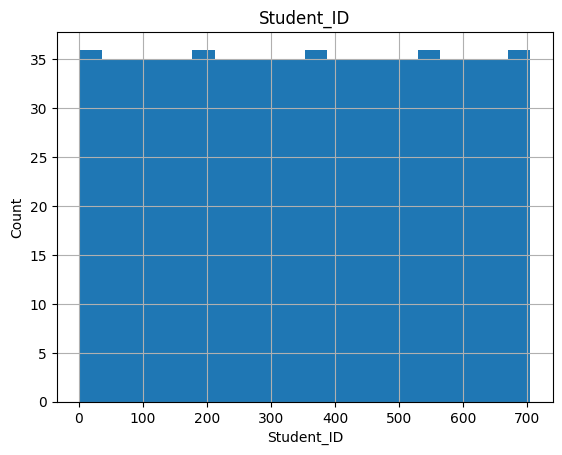

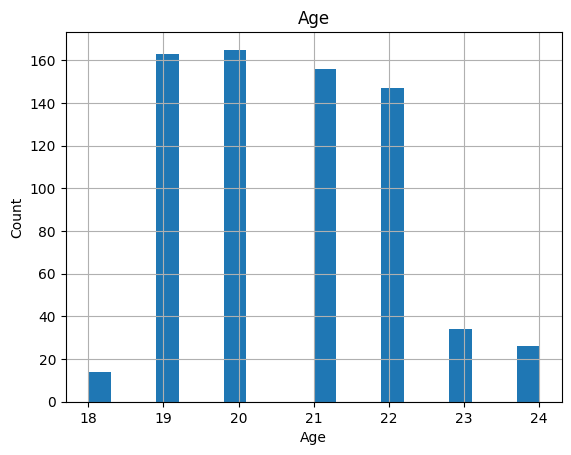

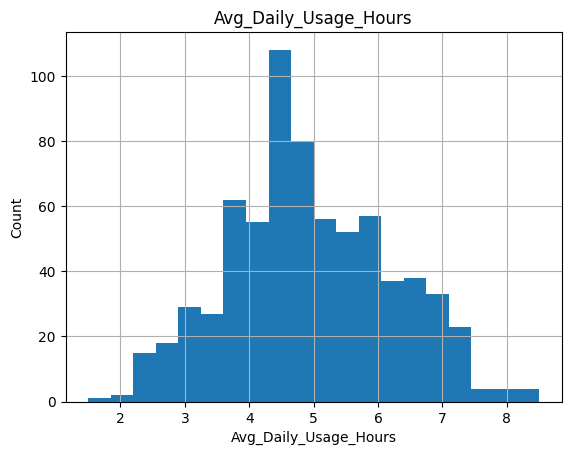

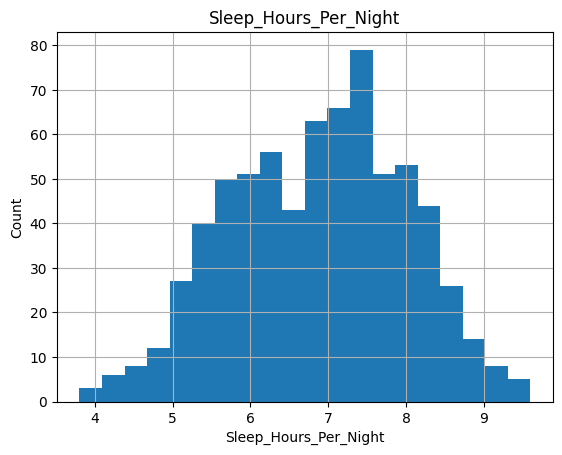

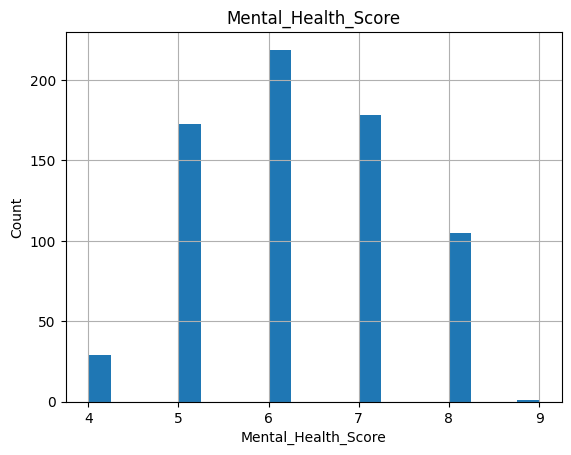

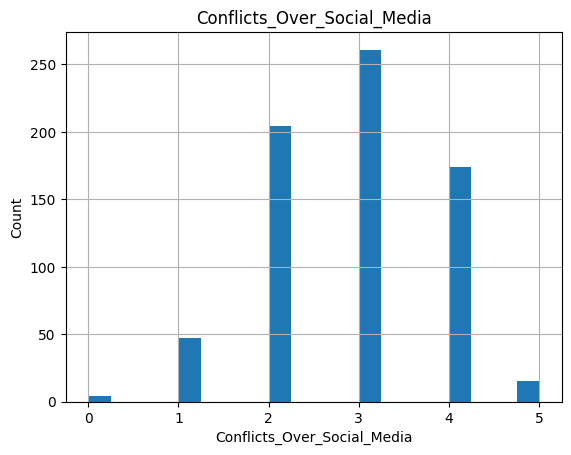

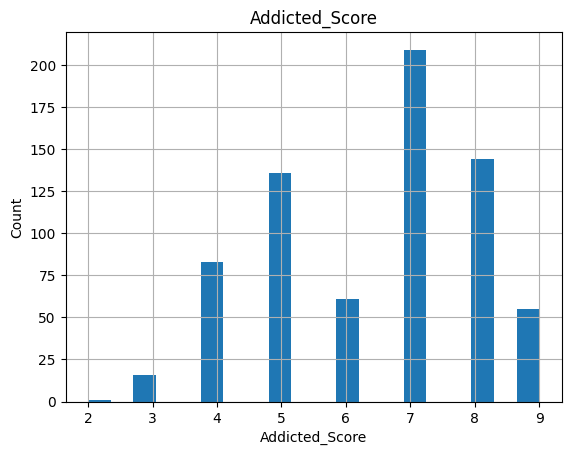

In [8]:
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

Given the analysis above, we can see that there is no missing data within the dataset.
The target data of the problem is each students’ mental health score, **Mental_Health_Score**. Given the dataset, the actionable columns that can be used to solve the problem are:
- `Avg_Daily_Usage_Hours`
- `Sleep_Hours_Per_Night`
- `Affects_Academic_Performance`
- `Conflicts_Over_Social_Media`
- `Addicted_Score`

While the rest of the data found within the dataset may correlate with the problem, it is important to remember that correlation does not equal causation. With this in mind the `Country`, `Gender`, `Academic_Level`, and `Relationship_Status` data will not be considered when accounting for the final **Mental_Health_Score**.

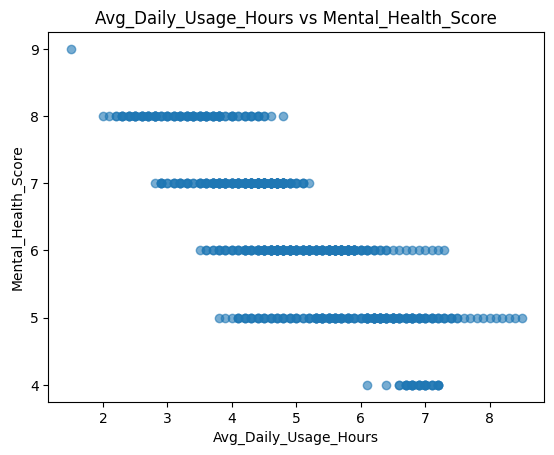

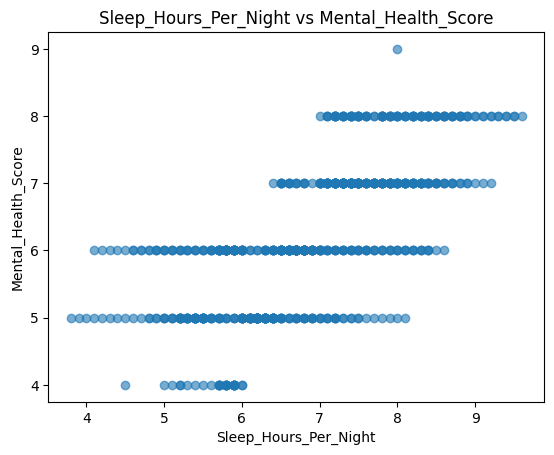

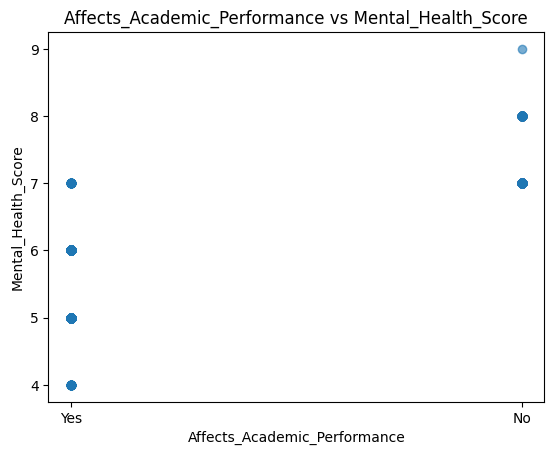

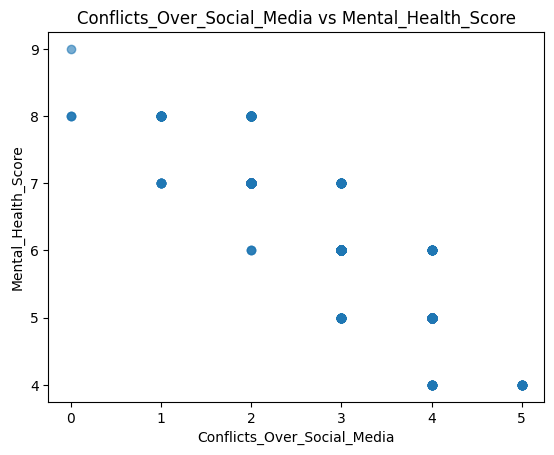

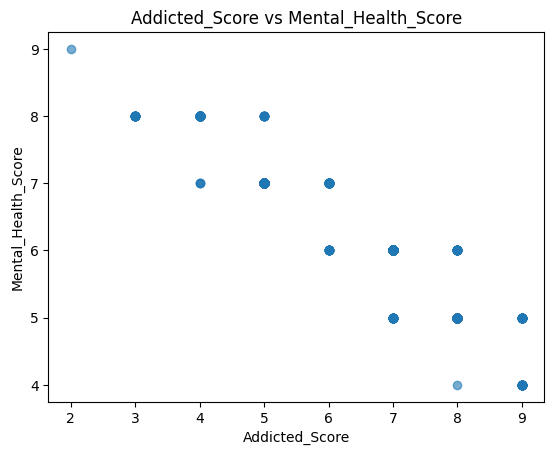

In [9]:
target_col = "Mental_Health_Score"

candidate_features = [
    "Avg_Daily_Usage_Hours",
    "Sleep_Hours_Per_Night",
    "Affects_Academic_Performance",
    "Conflicts_Over_Social_Media",
    "Addicted_Score"
]

for col in candidate_features:
    if col in df.columns:
        plt.figure()
        plt.scatter(df[col], df[target_col], alpha=0.6)
        plt.title(f"{col} vs {target_col}")
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.show()

**EDA Notes (write 5-8 bullet points):**

From the graphs above we can come to the following conclusions about the people in the dataset:
- The lower the screentime, the better their mental health
- The more sleep they get, the better their mental health
- The less conflicts they have over social media, the better their mental health
- The better their mental health, the less their academics are affected
- The less addicted they are, the better their mental health

From these conclusions I can establish a clear outline for improving mental health based on this data.

## Defining Features and Target
I will predict **Mental_Health_Score** using the remaining columns.

In [10]:
target_col = "Mental_Health_Score"

drop_cols = ["Student_ID"] #Drop the identifier column

X = df.drop(columns=[c for c in drop_cols + [target_col] if c in df.columns])
y = df[target_col].astype(float)

X.head(), y.head()

(   Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
 0   19  Female  Undergraduate  Bangladesh                    5.2   
 1   22    Male       Graduate       India                    2.1   
 2   20  Female  Undergraduate         USA                    6.0   
 3   18    Male    High School          UK                    3.0   
 4   21    Male       Graduate      Canada                    4.5   
 
   Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
 0          Instagram                          Yes                    6.5   
 1            Twitter                           No                    7.5   
 2             TikTok                          Yes                    5.0   
 3            YouTube                           No                    7.0   
 4           Facebook                          Yes                    6.0   
 
   Relationship_Status  Conflicts_Over_Social_Media  Addicted_Score  
 0     In Relationship                            

In [11]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_features, categorical_features

(['Age',
  'Avg_Daily_Usage_Hours',
  'Sleep_Hours_Per_Night',
  'Conflicts_Over_Social_Media',
  'Addicted_Score'],
 ['Gender',
  'Academic_Level',
  'Country',
  'Most_Used_Platform',
  'Affects_Academic_Performance',
  'Relationship_Status'])

## Train/Test Split


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

X_train.shape, X_test.shape

((564, 11), (141, 11))

## Baseline Models

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

def evaluate_regression(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [14]:
lin_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

lin_metrics = evaluate_regression(y_test, lin_pred, "Linear Regression")

Linear Regression -> MAE: 0.185 | RMSE: 0.261 | R2: 0.943


In [15]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_metrics = evaluate_regression(y_test, rf_pred, "Random Forest")

Random Forest -> MAE: 0.066 | RMSE: 0.217 | R2: 0.961


## Neural Network Model

Process:
- Fit the preprocessing pipeline on training data.
- Transform train/test features.
- Train a simple MLP regressor.

In [16]:
preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Convert to float32 tensors
X_train_t = torch.tensor(X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else X_train_enc, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

X_train_t.shape, y_train_t.shape

(torch.Size([564, 114]), torch.Size([564, 1]))

In [17]:
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

In [18]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLPRegressor(X_train_t.shape[1])
model

MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=114, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    all_preds = []
    all_true = []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()

        preds = model(xb)
        loss = criterion(preds, yb)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_true.append(yb.detach().cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.vstack(all_preds).ravel()
    all_true = np.vstack(all_true).ravel()
    return avg_loss, all_true, all_preds

In [20]:
best_val_rmse = float("inf")
best_state = None
patience = 15
patience_counter = 0
history = {"train_loss": [], "val_loss": [], "val_rmse": []}

EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    train_loss, _, _ = run_epoch(train_loader, train=True)
    val_loss, y_true, y_pred = run_epoch(test_loader, train=False)

    val_rmse = mean_squared_error(y_true, y_pred, squared=False)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_rmse"].append(val_rmse)

    if val_rmse < best_val_rmse - 1e-4:
        best_val_rmse = val_rmse
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val RMSE: {val_rmse:.4f}")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}. Best Val RMSE: {best_val_rmse:.4f}")
        break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 001 | Train Loss: 41.0083 | Val Loss: 39.6106 | Val RMSE: 6.2937
Epoch 020 | Train Loss: 0.3300 | Val Loss: 0.1011 | Val RMSE: 0.3180


In [21]:
model.eval()
_, y_true, y_pred = run_epoch(test_loader, train=False)

mlp_metrics = evaluate_regression(y_true, y_pred, "MLP (PyTorch)")

MLP (PyTorch) -> MAE: 0.220 | RMSE: 0.281 | R2: 0.934


## Training Curve

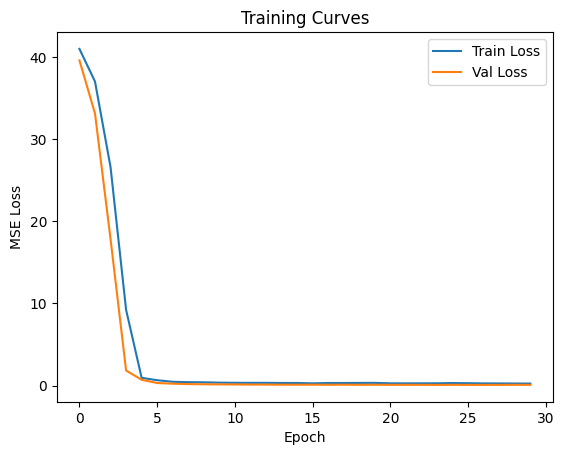

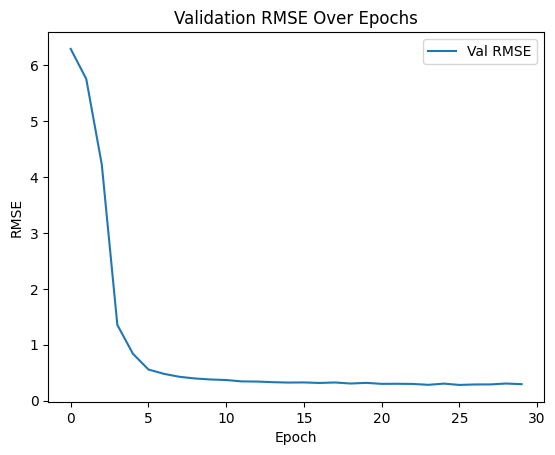

In [22]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curves")
plt.show()

plt.figure()
plt.plot(history["val_rmse"], label="Val RMSE")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE Over Epochs")
plt.show()

## Model Comparison Summary

The results table below shows which of the three models produced the best results, with the lowest mean absolute error, root mean squared error, and the highest R squared.

In [23]:
results = pd.DataFrame([
    {"Model": "Linear Regression", **lin_metrics},
    {"Model": "Random Forest", **rf_metrics},
    {"Model": "MLP (PyTorch)", **mlp_metrics},
])

results

,Model,MAE,RMSE,R2
0,Linear Regression,0.184974,0.260915,0.943295
1,Random Forest,0.065697,0.216516,0.960952
2,MLP (PyTorch),0.220022,0.281151,0.934158


To evaluate the effectiveness of an approach for predicting Mental_Health_Score based on my network, I compared three models: a Linear Regression baseline, a Random Forest Regressor baseline, and a PyTorch MLP as the primary neural network. Linear Regression served as a low-complexity reference point to measure the value of learning nonlinear relationships. Random Forest provided a strong traditional ML benchmark for tabular data. The MLP was selected based on the project’s requirement of training a neural network and implementing a downstream application.

In my experiments, the Random Forest achieved the strongest overall predictive performance, indicating that nonlinear interactions between factors such as Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, Addicted_Score, and Conflicts_Over_Social_Media are likely important for explaining variations in mental health. 

The Linear Regression baseline performed well but consistently behind the Random Forest, suggesting that purely linear assumptions are not sufficient to fully capture the dataset’s structure.

The MLP is expected to perform competitively, but because this is a relatively small dataset, it trends towards matching the linear baseline or approach the Random Forest only with careful tuning to avoid overfitting.

Crucially, even if the Random Forest slightly outperforms the MLP, the MLP remains the most suitable model for the application which follows: powering a what-if recommendation system. The neural model offers a smooth scoring function that can be used to simulate realistic behavior changes and rank the adjustments that yield the greatest predicted improvement in mental health. This transforms the trained network from a static predictor into a decision-support tool.

## Application: Personalized Recommendation System

As a demonstration of the models deployment, I will generate what-if recommendations by simulating realistic changes to actionable features and use the trained model to estimate the impact.

**Actionable features in this dataset:**
- `Avg_Daily_Usage_Hours`
- `Sleep_Hours_Per_Night`

I will keep suggestions small and reasonable as a generous example of how the models could be used.

In [24]:
def predict_mental_health(df_row):
    enc = preprocessor.transform(df_row)
    enc = enc.toarray() if hasattr(enc, "toarray") else enc
    xt = torch.tensor(enc, dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(xt).cpu().numpy().ravel()[0]
    return float(pred)

def clamp(val, lo, hi):
    return max(lo, min(hi, val))

def recommend_adjustments(user_row, top_k=3):
    """
    user_row: a single-row DataFrame with the same columns as X.
    Returns a list of recommendation dicts.
    """
    base_pred = predict_mental_health(user_row)

    recs = []

    # Candidate deltas
    usage_steps = [-0.5, -1.0, -1.5, -2.0]
    sleep_steps = [+0.5, +1.0, +1.5]

    # Bounds
    usage_lo, usage_hi = 0.0, 12.0
    sleep_lo, sleep_hi = 3.0, 10.0

    # Try usage reductions
    if "Avg_Daily_Usage_Hours" in user_row.columns:
        for d in usage_steps:
            trial = user_row.copy()
            cur = float(trial["Avg_Daily_Usage_Hours"].iloc[0])
            new = clamp(cur + d, usage_lo, usage_hi)
            if new != cur:
                trial.loc[:, "Avg_Daily_Usage_Hours"] = new
                pred = predict_mental_health(trial)
                recs.append({
                    "change": f"Reduce Avg_Daily_Usage_Hours from {cur:.1f} to {new:.1f}",
                    "new_pred": pred,
                    "improvement": pred - base_pred
                })

    # Try sleep increases
    if "Sleep_Hours_Per_Night" in user_row.columns:
        for d in sleep_steps:
            trial = user_row.copy()
            cur = float(trial["Sleep_Hours_Per_Night"].iloc[0])
            new = clamp(cur + d, sleep_lo, sleep_hi)
            if new != cur:
                trial.loc[:, "Sleep_Hours_Per_Night"] = new
                pred = predict_mental_health(trial)
                recs.append({
                    "change": f"Increase Sleep_Hours_Per_Night from {cur:.1f} to {new:.1f}",
                    "new_pred": pred,
                    "improvement": pred - base_pred
                })

    # Rank
    recs = sorted(recs, key=lambda r: r["improvement"], reverse=True)
    return base_pred, recs[:top_k]

In [25]:
# Demo on a random student
sample_idx = np.random.randint(0, len(X_test))
user_row = X_test.iloc[[sample_idx]].copy()

user_row

,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
30,21,Male,Undergraduate,Vietnam,3.6,Facebook,No,6.7,Single,1,5


In [26]:
base_pred, top_recs = recommend_adjustments(user_row, top_k=3)

print(f"Predicted Mental_Health_Score (current): {base_pred:.2f}")
print("\nTop Recommendations:")
for i, r in enumerate(top_recs, 1):
    print(f"{i}. {r['change']} -> new predicted score {r['new_pred']:.2f} (Δ {r['improvement']:+.2f})")

Predicted Mental_Health_Score (current): 7.08

Top Recommendations:
1. Reduce Avg_Daily_Usage_Hours from 3.6 to 1.6 -> new predicted score 7.45 (Δ +0.37)
2. Reduce Avg_Daily_Usage_Hours from 3.6 to 2.1 -> new predicted score 7.35 (Δ +0.27)
3. Reduce Avg_Daily_Usage_Hours from 3.6 to 2.6 -> new predicted score 7.25 (Δ +0.17)


## Discussion

The goal of the application side of this project was to move beyond prediction and demonstrate a novel use of my trained neural network. After training an MLP to estimate `Mental_Health_Score` from student social media and lifestyle indicators, the model was repurposed as a personalized recommendation engine. 
Instead of using the network only as an estimator, I treated it as a scoring function to evaluate behavior changes and to identify which adjustments were associated with the largest predicted improvement in mental well-being.

The recommendation system uses a simple 'what-if' simulation approach. For a given student profile, I generate small, realistic changes to actionable inputs—most notably `Avg_Daily_Usage_Hours` and `Sleep_Hours_Per_Night`—and then re-run the trained network to estimate the updated mental health prediction for each candidate scenario. The system ranks these options by predicted gain and returns the top suggestions. This design is intentionally lightweight and transparent: the user can clearly see what is being adjusted and how the predicted score responds. As a result, the model is repurposed in a user-facing way rather than leaving it as an isolated modeling exercise.

From a practical standpoint, this application highlights an important insight from the dataset: mental well-being appears to be more strongly associated with overall usage intensity and lifestyle balance than with any single platform identity alone. The system’s most common high-impact suggestions tend to involve reducing daily usage time and improving sleep duration, which aligns well with the intuitive expectation that social media moderation plays a key role in students’ mental wellness.

Overall, this system demonstrates the value of the trained neural network as a decision-support component. By converting predictions into targeted, personalized, and understandable lifestyle suggestions, the project shows a clear and practical example of training and application of the resulting network grounded in real student behavioral data.

## Conclusion

This project investigated the relationship between student social media habits, lifestyle factors, and mental well-being using the Students Social Media Addiction dataset. The central objective was to develop a machine learning solution that could predict a student’s `Mental_Health_Score` from features such as average daily usage, sleep duration, addiction score, and conflict related to social media, and then demonstrate a practical use of the trained model.

Across my modeling experiments, the results showed that mental health outcomes in this dataset are not explained by a single factor but instead reflect a pattern of usage intensity and balance-related behaviors. The baseline models provided useful context, while the neural network demonstrated that a compact MLP can learn meaningful relationships in this survey-style dataset. Even where a traditional model may offer competitive performance, the neural model remains central to the project’s contribution because it enables the second goal: a model-driven application.

The most important outcome of this project is the successful transformation of the trained network into a personalized recommendation system. By using a what-if simulation approach, the application converts predictions into actionable guidance. This shows how a predictive model can be integrated into a realistic wellness-support workflow rather than remaining purely analytical.


In summary, this project provides evidence that a machine learning approach can meaningfully estimate student mental well-being from social media and lifestyle indicators and demonstrates a compelling downstream use case through personalized recommendations. The work highlights both the promise and the responsibility of deploying predictive models in wellness-related contexts and offers a solid foundation for future expansion into more robust, ethically grounded digital health tools.